# Using LSTM and Conv1D to predict stock price



# Prepare and Preprocess Data

In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in Farma-French five factor data downloaded from Kenneth R. French Data Library

In [149]:
ff_5=pd.read_excel('/content/drive/MyDrive/Deep Learning Datasets/Final Project/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip (Unzipped Files) (1)/F-F_Research_Data_5_Factors_2x3_daily.xlsx',header=3,names=['Date','Mkt-Rf','SMB','HML','RMW','CMA','RF'])
ff_5.head()

,Date,Mkt-Rf,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.01,-0.35,0.03,0.11,0.012
1,19630702,0.79,-0.31,0.24,-0.08,-0.25,0.012
2,19630703,0.63,-0.16,-0.09,0.13,-0.24,0.012
3,19630705,0.40,0.09,-0.26,0.07,-0.28,0.012
4,19630708,-0.63,0.07,-0.19,-0.27,0.06,0.012


In [150]:
import time
ff_5['Date']=[pd.to_datetime(str(i)[:4]+'/'+str(i)[4:6]+'/'+str(i)[6:]) for i in ff_5['Date']] # parse the date informaiton

In [151]:
ff_5=ff_5.loc[(ff_5['Date']>='2019-02-28')&(ff_5['Date']<'2022-02-28')]

In [152]:
ff_5

,Date,Mkt-Rf,SMB,HML,RMW,CMA,RF
14010,2019-02-28,-0.31,-0.02,-0.25,0.29,0.16,0.010
14011,2019-03-01,0.72,0.25,-0.41,-0.35,-0.18,0.009
14012,2019-03-04,-0.52,-0.38,0.39,0.14,-0.09,0.009
14013,2019-03-05,-0.17,-0.32,-0.23,0.28,0.00,0.009
14014,2019-03-06,-0.84,-1.23,0.05,0.55,0.12,0.009
...,...,...,...,...,...,...,...
14761,2022-02-18,-0.87,0.12,0.93,1.02,0.39,0.000
14762,2022-02-22,-1.18,-0.37,0.12,-0.06,0.12,0.000
14763,2022-02-23,-1.96,0.07,1.25,0.00,1.07,0.000
14764,2022-02-24,1.88,0.67,-3.85,-1.74,-1.75,0.000


## Read in last 10 years' stock daily price data for S&P 500 companies from Yahoo finance API

In [153]:
# tickers of all s&p 500 firms
tickers = pd.read_excel('/content/drive/MyDrive/Deep Learning Datasets/Final Project/SP500 Listed Companies.xlsx')
tickers.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Date first added,Founded
0,A,Agilent Technologies,Health Care,Health Care Equipment,2000-06-05 00:00:00,1999
1,AAL,American Airlines Group,Industrials,Airlines,2015-03-23 00:00:00,1934
2,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,2015-07-09 00:00:00,1932
3,AAPL,Apple,Information Technology,"Technology Hardware, Storage & Peripherals",1982-11-30 00:00:00,1977
4,ABBV,AbbVie,Health Care,Pharmaceuticals,2012-12-31 00:00:00,2013 (1888)


In [389]:
stocks_for_model=tickers.Symbol.sample(300)

In [420]:
# download data from Yahoo finance dataset
history_data={}
for i in stocks_for_model:
    connect=yf.Ticker(i)
    history_data[i] = connect.history(start='2019-02-28',end='2022-02-28')

- BRK.B: No data found, symbol may be delisted


In [421]:
history_data.pop('BRK.B')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [422]:
# match the data with ff 5 factor model and concatenate them together in a large dataframe
for i in history_data.keys():
    history_data[i]=pd.merge(history_data[i],ff_5,on='Date')

In [423]:
from keras.backend import shape
# concatinate all the dataframes, drop the irrelevant columns, normalize (using MinMax) stock price and store the dataframe to a new csv files for future use

# import and initialize the minmax_scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data=None
for i in history_data.keys():
    history_data[i]['Ticker']=np.repeat(i,len(history_data[i]))
    history_data[i].drop(['Open','High','Low','Volume'],axis=1,inplace=True)
    history_data[i]['Close']=scaler.fit_transform(history_data[i]['Close'].values.reshape(-1,1))
    if data is None:
        data=history_data[i]
    else:
        data=pd.concat([data,history_data[i]],ignore_index=True)

In [424]:
data.to_csv('/content/sample_sp500_data.csv')

In [425]:
!cp sample_sp500_data.csv '/content/drive/MyDrive/Deep Learning Datasets/Final Project/'

# After disconnected, use the saved data instead of starting from scratch

In [418]:
data = pd.read_csv('/content/drive/MyDrive/Deep Learning Datasets/Final Project/sample_sp500_data.csv')

In [426]:
from sklearn.model_selection import train_test_split
# take the sample of 100 stocks in S&P 500 for training and validating
train, test_tickers= train_test_split(data['Ticker'].unique(),train_size=0.9)
train_tickers,val_tickers=train_test_split(data['Ticker'].unique(),train_size=0.8)

## Prepare the data for NNs

Since the data we obtained previously is a simple time series data, we need to process the data in order to fit it to the deep learning models.

In [399]:
# define a function to generate 3D array to feed lstm model that allows customized look back period and delay period
def batch_generator(data, lookback, delay, min_index, max_index=None, batch_size=18, step=1,nbatch=0):
    if max_index is None:
        max_index=len(data)-delay-1 # save enough data for the last prediction
    i= min_index + lookback+nbatch
    # make sure there's enough data for a batch
    data.drop(columns='Ticker',inplace=True)
    if i+batch_size<=max_index:
        rows = np.arange(i,min(i+batch_size,max_index))

        samples=np.zeros((len(rows),lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices=range(rows[j]-lookback,rows[j],step)
            samples[j]=data.loc[indices,['Close','Dividends','Stock Splits','Mkt-Rf','SMB','HML','RMW','CMA','RF']]
            targets[j]=data.loc[rows[j]+delay,'Close']
        
        return samples, targets

In [400]:
def generator(data,tickers,lookback, delay, batch_size, step=1):
    while 1:
        for i in tickers:
            for j in range((len(data.loc[data.Ticker==i,])-lookback)-batch_size):
                samples,targets=batch_generator(data.loc[data.Ticker==i, ],
                                lookback=lookback, 
                                delay=delay, 
                                min_index=min(data.loc[data.Ticker==i, ].index), 
                                max_index=max(data.loc[data.Ticker==i, ].index),
                                nbatch=j,
                                batch_size=batch_size)
                yield samples,targets        

<font color=blue> Normally, LSTM is used on one single trend and analyze its development over time. However, in stock market, we can spot similar trends in many different stocks. To use data from multiple stocks to train the data, we need to make sure that the data of different stocks don't overlap with each other. Therefore, we are going to first generate data for each stock and combine them together.

In [428]:
# seperate the data into training and validation set
train_data=data.loc[data.Ticker.isin(train_tickers),data.columns!='Date']
val_data = data.loc[data.Ticker.isin(val_tickers),data.columns!='Date']
test_data = data.loc[data.Ticker.isin(test_tickers),data.columns!='Date']

In [429]:
# reset the index so that we can use index to slice the data set later
train_data.index=range(train_data.shape[0])
val_data.index=range(val_data.shape[0])
test_data.index=range(test_data.shape[0])

In [507]:
# set some of the parameters
lookback= 30         # use 20 past observations to predict the next day
delay=0              # model is set to predict the stock price the very next day
min_index=0          # we are using the full dataset
batch_size = 18      # batch-size set to 18
train_gen=generator(train_data,train_tickers, lookback,delay, batch_size)
val_gen=generator(val_data,val_tickers, lookback, delay, batch_size)

# Model Fitting (DNN, CNN, LSTM and more)

<font color=blue> To find the best model, we aimed to first overfit the model and then add regularization and other tunning methods.

## Baseline Accuracy (using 5-day sliding window mean)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.4938731438410368


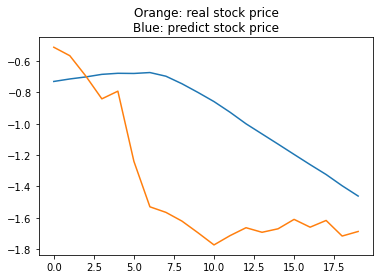

In [434]:
from matplotlib import pyplot as plt
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (90*700 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
#test_steps = (len(float_data) - 3001 - lookback) // batch_size

def evaluate_naive_method():
    batch_mae = []
    pred = []
    target= []
    for step in range(20):
        samples, targets = next(val_gen)
        pred.append(np.mean(targets[-21:-2]))
        target.append(targets[-1])
        mae = np.abs((pred[-1] - target[-1]))
        batch_mae.append(mae)
    print(np.mean(batch_mae))
    return pred,target

# Let's plot the most recent validation batch
preds,targets = evaluate_naive_method()
plt.plot(range(len(preds)),preds)
plt.plot(range(len(targets)),targets)
plt.title("Orange: real stock price\nBlue: predict stock price")
plt.show()

## First try using dense nerual network

In [435]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, LSTM, GRU, Dropout, MaxPool1D
from tensorflow.keras.optimizers import RMSprop, Adam

In [436]:
# fit the model with two hidden layers
model = Sequential()
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='RMSprop')

model_fit = model.fit_generator(train_gen, epochs=80,steps_per_epoch=18,validation_data=val_gen,validation_steps=20)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


18/18 [==============================] - 2s 87ms/step - loss: 0.3830 - val_loss: 1.4457
Epoch 2/80
18/18 [==============================] - 1s 79ms/step - loss: 0.1178 - val_loss: 1.2601
Epoch 3/80
18/18 [==============================] - 2s 89ms/step - loss: 0.1268 - val_loss: 0.8314
Epoch 4/80
18/18 [==============================] - 1s 79ms/step - loss: 0.1728 - val_loss: 0.5784
Epoch 5/80
18/18 [==============================] - 2s 89ms/step - loss: 0.3340 - val_loss: 0.5424
Epoch 6/80
18/18 [==============================] - 2s 89ms/step - loss: 0.1995 - val_loss: 0.8621
Epoch 7/80
18/18 [==============================] - 1s 82ms/step - loss: 0.1479 - val_loss: 1.5823
Epoch 8/80
18/18 [==============================] - 1s 83ms/step - loss: 0.1167 - val_loss: 1.5357
Epoch 9/80
18/18 [==============================] - 2s 90ms/step - loss: 0.1425 - val_loss: 0.8242
Epoch 10/80
18/18 [==============================] - 1s 82ms/step - loss: 0.1931 - val_loss: 0.4452
Epoch 11/80
18/18 [=

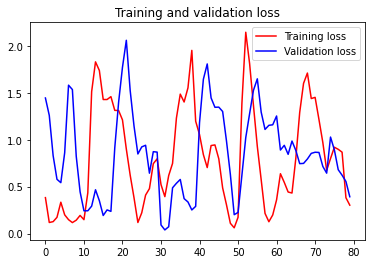

In [437]:
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [438]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, None)              0         
                                                                 
 dense_32 (Dense)            (None, 256)               69376     
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 102,401
Trainable params: 102,401
Non-trainable params: 0
_________________________________________________________________


## Add a Conv1D layer as a window

In [439]:
model2 = Sequential()

model2.add(Conv1D(18,5))
model2.add(MaxPool1D(2))
model2.add(Flatten())
model2.add(Dense(512,activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='relu'))

model2.compile(loss='mae', optimizer='RMSprop',metrics=['mse','mae'])
model2_fit = model2.fit_generator(train_gen, epochs=80,steps_per_epoch=18,validation_data=val_gen,validation_steps=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/80
18/18 [==============================] - 2s 98ms/step - loss: 0.1775 - mse: 0.0506 - mae: 0.1775 - val_loss: 0.3636 - val_mse: 0.1437 - val_mae: 0.3636
Epoch 2/80
18/18 [==============================] - 1s 86ms/step - loss: 0.1770 - mse: 0.0484 - mae: 0.1770 - val_loss: 0.2668 - val_mse: 0.0781 - val_mae: 0.2668
Epoch 3/80
18/18 [==============================] - 1s 86ms/step - loss: 0.4527 - mse: 0.2553 - mae: 0.4527 - val_loss: 0.1479 - val_mse: 0.0321 - val_mae: 0.1479
Epoch 4/80
18/18 [==============================] - 2s 91ms/step - loss: 0.2507 - mse: 0.0976 - mae: 0.2507 - val_loss: 0.0649 - val_mse: 0.0059 - val_mae: 0.0649
Epoch 5/80
18/18 [==============================] - 2s 91ms/step - loss: 0.1924 - mse: 0.0441 - mae: 0.1924 - val_loss: 0.0772 - val_mse: 0.0100 - val_mae: 0.0772
Epoch 6/80
18/18 [==============================] - 1s 84ms/step - loss: 0.2857 - mse: 0.0904 - mae: 0.2857 - val_loss: 0.2470 - val_mse: 0.0748 - val_mae: 0.2470
Epoch 7/80
18/18 [====

In [440]:
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 18)          828       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 18)         0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, None)              0         
                                                                 
 dense_35 (Dense)            (None, 512)               120320    
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 dense_37 (Dense)            (None, 1)                 257       
                                                     

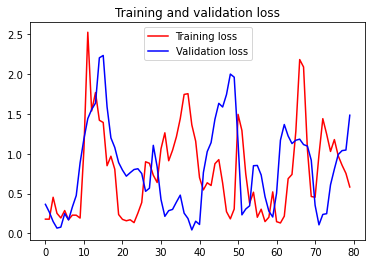

In [441]:
from matplotlib import pyplot as plt
loss = model2_fit.history['loss']
val_loss = model2_fit.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## LSTM model

In [614]:
model3=Sequential()
#model3.add(LSTM(30,return_sequences=True))
model3.add(LSTM(30))
#model3.add(Dense(128, activation='relu'))
#model3.add(Dense(64, activation='relu'))
model3.add(Dense(1,activation='relu'))

model3.compile(loss='mae', optimizer='Adam',metrics=['mape'])

model3_fit = model3.fit_generator(train_gen, epochs=40,steps_per_epoch=18,validation_data=val_gen,validation_steps=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/40
18/18 [==============================] - 4s 114ms/step - loss: 0.7993 - mape: 67.1322 - val_loss: 0.9352 - val_mape: 100.0000
Epoch 2/40
18/18 [==============================] - 2s 91ms/step - loss: 0.1204 - mape: 13.8305 - val_loss: 0.7266 - val_mape: 100.0000
Epoch 3/40
18/18 [==============================] - 1s 83ms/step - loss: 0.0807 - mape: 12.7100 - val_loss: 0.5382 - val_mape: 101.2404
Epoch 4/40
18/18 [==============================] - 1s 83ms/step - loss: 0.1112 - mape: 13.4532 - val_loss: 0.3233 - val_mape: 115.5067
Epoch 5/40
18/18 [==============================] - 1s 84ms/step - loss: 0.1416 - mape: 18.6121 - val_loss: 0.3342 - val_mape: 179.5383
Epoch 6/40
18/18 [==============================] - 1s 85ms/step - loss: 0.1282 - mape: 15.0298 - val_loss: 0.4976 - val_mape: 137.2657
Epoch 7/40
18/18 [==============================] - 1s 83ms/step - loss: 0.1341 - mape: 56.5324 - val_loss: 1.0568 - val_mape: 103.0421
Epoch 8/40
18/18 [=============================

In [449]:
model3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, None, 30)          4800      
                                                                 
 lstm_23 (LSTM)              (None, 30)                7320      
                                                                 
 dense_41 (Dense)            (None, 128)               3968      
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24,409
Trainable params: 24,409
Non-trainable params: 0
_________________________________________________________________


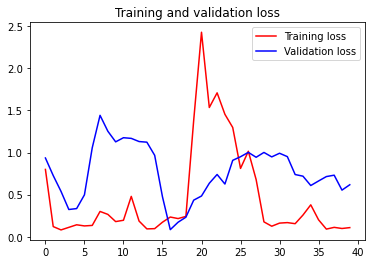

In [615]:
from matplotlib import pyplot as plt
loss = model3_fit.history['loss']
val_loss = model3_fit.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Regularization to find the best model

<font color=green> From the previous three models, we can see that the LSTM model has the best fitting power and massively overfittedd the data. Therefore, we are using LSTM as a starting point to use different regularizations to fix the overfitting problem

In [611]:
model5=Sequential()
# here we connected two LSTM layers to further increase the complexity of the model
model5.add(LSTM(30,dropout=0.1,recurrent_dropout=0.1,return_sequences=False))  # set the dropout rate and recurrent dropout rate to 0.2
model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(1,activation='relu'))

model5.compile(loss='mae', optimizer='Adam',metrics=['mape'])

# add early stopping
Es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model5_fit = model5.fit_generator(train_gen, 
                                  epochs=40,
                                  steps_per_epoch=18,
                                  validation_data=val_gen,
                                  validation_steps=40,
                                  callbacks=[Es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/40
18/18 [==============================] - 7s 245ms/step - loss: 0.2612 - mape: 138.6023 - val_loss: 2.1578 - val_mape: 97.2871
Epoch 2/40
18/18 [==============================] - 4s 230ms/step - loss: 1.6697 - mape: 100.8485 - val_loss: 1.4224 - val_mape: 94.3894
Epoch 3/40
18/18 [==============================] - 4s 227ms/step - loss: 2.0693 - mape: 100.0000 - val_loss: 1.0286 - val_mape: 100.0000
Epoch 4/40
18/18 [==============================] - 7s 394ms/step - loss: 1.7934 - mape: 100.0000 - val_loss: 0.7817 - val_mape: 100.0000
Epoch 5/40
18/18 [==============================] - 4s 230ms/step - loss: 1.2423 - mape: 100.0337 - val_loss: 0.7548 - val_mape: 100.0000
Epoch 6/40
18/18 [==============================] - 4s 231ms/step - loss: 0.9037 - mape: 100.0137 - val_loss: 0.8141 - val_mape: 100.0000
Epoch 7/40
18/18 [==============================] - 4s 230ms/step - loss: 0.4884 - mape: 100.0000 - val_loss: 0.5566 - val_mape: 100.0000
Epoch 8/40
18/18 [==================

In [609]:
model5.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 30)                4800      
                                                                 
 dense_60 (Dense)            (None, 128)               3968      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 1)                 129       
                                                                 
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


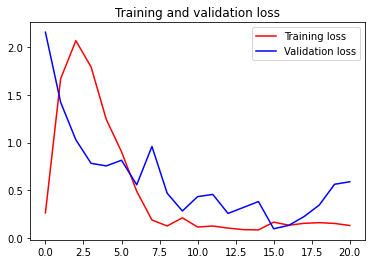

In [612]:
loss = model5_fit.history['loss']
val_loss = model5_fit.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [613]:
model5.save('/content/Stock_Pred.h5')

# Multi period prediction

<font color=blue>Now, to demonstrate the performance of our model, we are now applying the model to make prediction on some test data.

## Prediction for PNC Financial Service Group

In [587]:
test_tickers

array(['HST', 'AIZ', 'CNC', 'TXT', 'BEN', 'HAS', 'MCD', 'STE', 'PNC',
       'BLL', 'UA', 'AIG', 'WEC', 'GOOGL', 'AAPL', 'LYB', 'CTAS', 'RCL',
       'RE', 'UDR', 'DHR', 'STT', 'ANET', 'AWK', 'WBA', 'WELL', 'TDY',
       'LNT', 'MOS', 'CCL'], dtype=object)

In [598]:
MMM = data.loc[(data.Ticker=='PNC'),]
MMM_target = MMM.loc[MMM.index>=(max(MMM.index)-60),]

In [599]:
test_gen = generator(MMM_target.loc[:,data.columns!='Date'],['PNC'],lookback=30,delay=0,batch_size=1,step=1,)

In [600]:
prediction=[]
for i in range(30):
    pred=model5.predict_generator(test_gen,steps=1)
    pred=pred[0][0]
    prediction.append(pred)
prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[1.551079,
 1.5647913,
 1.5088632,
 1.4155971,
 1.4439528,
 1.3979284,
 1.3194157,
 1.3524457,
 1.321829,
 1.4221925,
 1.3539958,
 1.4130603,
 1.3758392,
 1.3111897,
 1.3122069,
 1.551079,
 1.5647913,
 1.5088632,
 1.4155971,
 1.4439528,
 1.3979284,
 1.3194157,
 1.3524457,
 1.321829,
 1.4221925,
 1.3539958,
 1.4130603,
 1.3758392,
 1.3111897,
 1.3122069]

In [601]:
prediction=np.array(prediction).reshape(1,-1)

In [602]:
prediction=prediction[0]

In [603]:
actual=MMM_target.loc[MMM_target.index>=(max(MMM_target.index)-30),'Close']

In [604]:
MMM_previous = MMM.loc[MMM.index<(max(MMM.index)-60),'Close']

In [605]:
MMM_actual = [i for i in MMM_previous[500:]]
for i in actual:
    MMM_actual.append(i)

In [606]:
MMM_pred=[i for i in MMM_previous[500:]]
for i in prediction:
    MMM_pred.append(i)

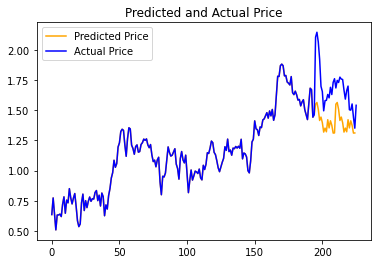

In [607]:
plt.figure()

plt.plot(range(len(MMM_pred)), MMM_pred, 'orange', label='Predicted Price')
plt.plot(range(len(MMM_actual)), MMM_actual, 'b', label='Actual Price')
plt.title('Predicted and Actual Price')
plt.legend()

plt.show()

## Prediction for Google

In [537]:
val_tickers

array(['KHC', 'IVZ', 'INTU', 'EFX', 'NTAP', 'NWSA', 'EA', 'ORCL', 'ANSS',
       'ISRG', 'TROW', 'STX', 'MRNA', 'POOL', 'FB', 'UDR', 'LYV', 'AZO',
       'TMUS', 'ADP', 'PKG', 'UNH', 'AEE', 'STE', 'ABMD', 'ZION', 'MDLZ',
       'CTXS', 'EPAM', 'DXC', 'NWS', 'LW', 'MSI', 'CHTR', 'ADBE', 'ROP',
       'MLM', 'NEM', 'WAT', 'NLOK', 'PCAR', 'NI', 'OXY', 'AMP', 'BKR',
       'IFF', 'GILD', 'RSG', 'HAL', 'AIZ', 'BAX', 'PM', 'J', 'JBHT',
       'PHM', 'BBY', 'STT', 'PFG', 'ABBV', 'CPT'], dtype=object)

In [556]:
# select a stock
MMM = data.loc[(data.Ticker=='GOOGL'),]
MMM_target = MMM.loc[MMM.index>=(max(MMM.index)-60),]

In [576]:
test_gen = generator(MMM_target.loc[:,data.columns!='Date'],['GOOGL'],lookback=30,delay=0,batch_size=1,step=1,)

In [577]:
prediction=[]
for i in range(30):
    pred=model5.predict_generator(test_gen,steps=1)
    pred=pred[0][0]
    prediction.append(pred)
prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[1.4633179,
 1.4473536,
 1.3505652,
 1.2659779,
 1.3054276,
 1.2480649,
 1.1766573,
 1.238304,
 1.2549068,
 1.3689886,
 1.3014928,
 1.3429782,
 1.3072609,
 1.2411444,
 1.2231569,
 1.4633179,
 1.4473536,
 1.3505652,
 1.2659779,
 1.3054276,
 1.2480649,
 1.1766573,
 1.238304,
 1.2549068,
 1.3689886,
 1.3014928,
 1.3429782,
 1.3072609,
 1.2411444,
 1.2231569]

In [578]:
prediction=np.array(prediction).reshape(1,-1)
prediction=prediction[0]

In [579]:
MMM_previous = MMM.loc[MMM.index<(max(MMM.index)-60),'Close']

In [580]:
actual=MMM_target.loc[MMM_target.index>=(max(MMM_target.index)-30),'Close']

In [581]:
MMM_actual = [i for i in MMM_previous[500:]]
for i in actual:
    MMM_actual.append(i)

In [582]:
MMM_pred=[i for i in MMM_previous[500:]]
for i in prediction:
    MMM_pred.append(i)

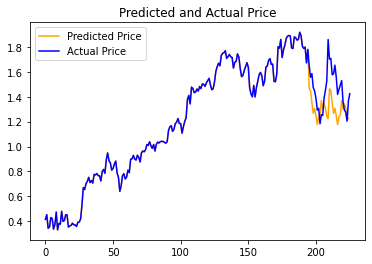

In [583]:
plt.figure()

plt.plot(range(len(MMM_pred)), MMM_pred, 'orange', label='Predicted Price')
plt.plot(range(len(MMM_actual)), MMM_actual, 'b', label='Actual Price')
plt.title('Predicted and Actual Price')
plt.legend()

plt.show()